In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold,train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import SelectFromModel 
from sklearn.decomposition import TruncatedSVD
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_rows', None)
pd.set_option("max_colwidth", None)

In [2]:
train=pd.read_csv('train.csv')

In [3]:
train.shape

(1460, 81)

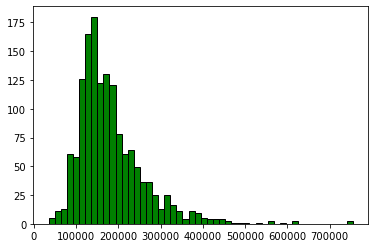

In [8]:
plt.hist(train['SalePrice'],bins=50 ,color='green',edgecolor='k');

##  Replacing missing values

In [5]:
#Just as is stated in the data description section for this dataset, the following columns are categorical variables 
#that have the value "NA" which refers to for example No pool, No Fence, etc.
#For this reason the nan are going to be replaced with the value "None"

with_NA_type=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',
              'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

for i in with_NA_type:
    train.loc[:,i]=train.loc[:,i].fillna('None')

In [6]:
#LotFrontage : Since the area of each street connected to the house property most likely have a similar 
#area to other houses in its neighborhood,we can fill in missing values by the median LotFrontage of the neighborhood.
#By (https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [7]:
#Other missing variables
train.isna().sum()[train.isna().sum()>0]

MasVnrType      8
MasVnrArea      8
Electrical      1
GarageYrBlt    81
dtype: int64

In [8]:
#MasVnrArea variable depends to the MasVnrType, since both have only 8 missing values, let's drop them
train['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [9]:
train[['MasVnrArea','MasVnrType']][train['MasVnrType'].isna()]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [10]:
#Drop Electrical, MasVnrArea, MasVnrType as they have a few missing values
train=train.dropna(subset=["Electrical", "MasVnrArea", "MasVnrType"])

In [11]:
#Since GarageArea is equal to 0 where GarageYrBlt is missing: We should replace the missing with 0
train['GarageArea'][train['GarageYrBlt'].isna()].sum()

0

In [12]:
train.loc[:,['GarageArea','GarageYrBlt']]=train[['GarageArea','GarageYrBlt']].fillna(0).values

In [13]:
train.shape

(1451, 81)

In [14]:
train.drop(columns='Id',inplace=True)

**The following function called "select_model" is going to retun the pipeline used in each estimation.**

In [15]:
def select_model(model_name,col_transform,selector=False,dim_red=False):
    '''
    model_name: Call the regressor
    col_transform: Specify the ColumnTransformer method
    selector: If True, introduce SelectFromModel into the pipeline.
    dim_red: If True, introduce TruncatedSVD into the pipeline
    '''
    
    if (selector==True & dim_red==True):
        param_list=[('prep', col_transform),
                       ("select", SelectFromModel(model_name,max_features=1,threshold=-np.inf)),
                    ('reduct',TruncatedSVD()),
                       ('model',model_name)]

    elif selector==True:
        param_list=[('prep', col_transform),
                       ('select', SelectFromModel(model_name,max_features=1,threshold=-np.inf)),
                       ('model',model_name)]
        
    elif dim_red==True:
        param_list=[('prep', col_transform),
                       ('reduct',TruncatedSVD()),
                       ('model',model_name)]
       
    else:
        param_list=[('prep', col_transform),
                       ('model',model_name)]
    
    pipe = Pipeline(steps=param_list)
    return pipe

In [16]:
train_x=train.iloc[:,:-1]
train_y=pd.DataFrame(train['SalePrice'])

numerical_ix = train_x.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = train_x.select_dtypes(include=['object', 'bool']).columns

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

# First experiment: Use all variables and apply dimension reduction

In [17]:
t1 = [('cat', OneHotEncoder(handle_unknown = "ignore"), categorical_ix), 
     ('num', StandardScaler(), numerical_ix)]

col_transform1 = ColumnTransformer(transformers=t1)

In [17]:
params={"model__max_depth":Integer(10,800),
       "model__max_features":Real(0.5,1),
       "reduct__n_components":Integer(2,40)}

result_dt = BayesSearchCV(estimator=select_model(DecisionTreeRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_dt.fit(X_train,y_train.values.ravel())

print(result_dt.best_params_)
print(-result_dt.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__max_depth', 10), ('model__max_features', 1.0), ('reduct__n_components', 7)])
34515.88810654049


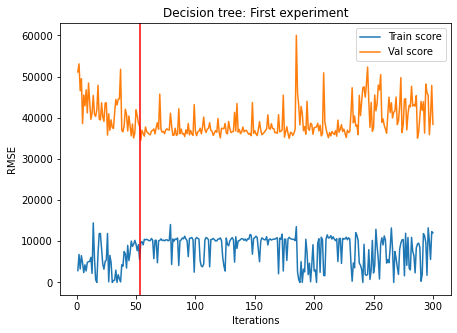

In [18]:
plt.figure(figsize=(7,5))
train_score=np.array(result_dt.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_dt.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Decision tree: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_dt.best_index_,c='r')
plt.show()

In [19]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "reduct__n_components":Integer(2,40)}

result_rf = BayesSearchCV(estimator=select_model(RandomForestRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_rf.fit(X_train,y_train.values.ravel())

print(result_rf.best_params_)
print(-result_rf.best_score_)

OrderedDict([('model__bootstrap', False), ('model__max_depth', 72), ('model__max_features', 0.636089893631592), ('model__max_samples', 0.5), ('model__n_estimators', 123), ('reduct__n_components', 10)])
28972.099794836296


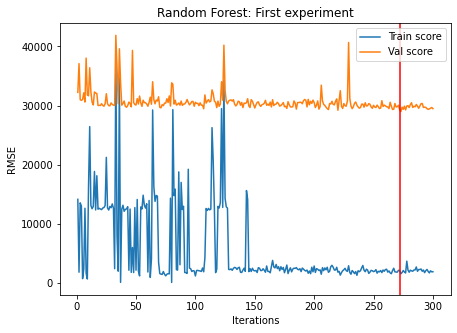

In [20]:
plt.figure(figsize=(7,5))
train_score=np.array(result_rf.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_rf.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Random Forest: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_rf.best_index_,c='r')
plt.show()

In [21]:
params={"model__n_estimators":Integer(100,1000),
       "model__learning_rate":Real(0.01,0.1),
       "reduct__n_components":Integer(2,40)}

result_ada = BayesSearchCV(estimator=select_model(AdaBoostRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_ada.fit(X_train,y_train.values.ravel())

print(result_ada.best_params_)
print(-result_ada.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__learning_rate', 0.05367052679381856), ('model__n_estimators', 1000), ('reduct__n_components', 10)])
30367.48175695223


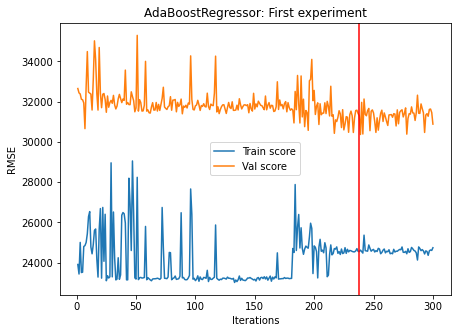

In [22]:
plt.figure(figsize=(7,5))
train_score=np.array(result_ada.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_ada.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('AdaBoostRegressor: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_ada.best_index_,c='r')
plt.show()

In [23]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "reduct__n_components":Integer(2,40)}

result_extra = BayesSearchCV(estimator=select_model(ExtraTreesRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)


result_extra.fit(X_train,y_train.values.ravel())

print(result_extra.best_params_)
print(-result_extra.best_score_)

OrderedDict([('model__bootstrap', False), ('model__max_depth', 75), ('model__max_features', 0.7209730156235719), ('model__max_samples', 0.99), ('model__n_estimators', 813), ('reduct__n_components', 10)])
28691.456909887962


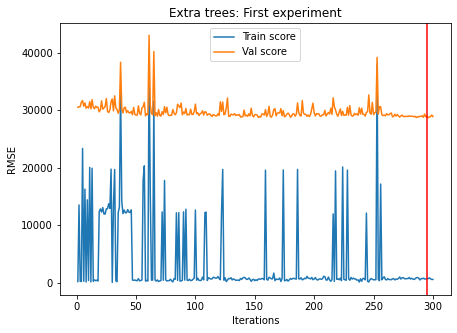

In [24]:
plt.figure(figsize=(7,5))
train_score=np.array(result_extra.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_extra.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Extra trees: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_extra.best_index_,c='r')
plt.show()

In [25]:
params={"model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "reduct__n_components":Integer(2,40)}

result_gbr = BayesSearchCV(estimator=select_model(GradientBoostingRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_gbr.fit(X_train,y_train.values.ravel())

print(result_gbr.best_params_)
print(-result_gbr.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('model__max_depth', 3), ('model__max_features', 1.0), ('model__n_estimators', 100), ('model__subsample', 0.6102816308755314), ('reduct__n_components', 10)])
27516.856940817266


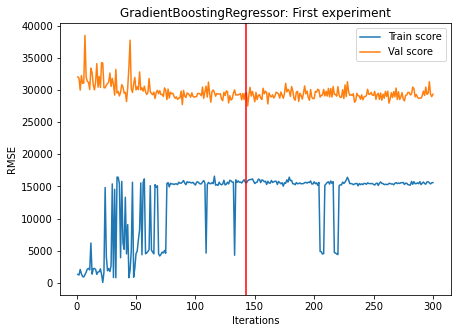

In [26]:
plt.figure(figsize=(7,5))
train_score=np.array(result_gbr.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_gbr.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('GradientBoostingRegressor: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_gbr.best_index_,c='r')
plt.show()

In [27]:
params={"model__learning_rate":Real(0.01,0.1),
       "model__max_depth":Integer(1,8),
       "model__n_estimators":Integer(100,1000),
       "model__colsample_bytree":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "reduct__n_components":Integer(2,40)}

result_xgb = BayesSearchCV(estimator=select_model(XGBRegressor(),col_transform1,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)
result_xgb.fit(X_train,y_train.values.ravel())

print(result_xgb.best_params_)
print(-result_xgb.best_score_)

OrderedDict([('model__colsample_bytree', 1.0), ('model__learning_rate', 0.087706537611456), ('model__max_depth', 7), ('model__n_estimators', 418), ('model__subsample', 0.5), ('reduct__n_components', 14)])
25725.5268572925


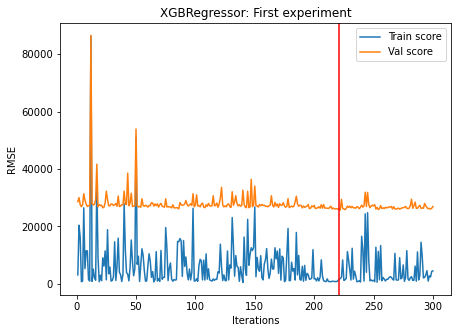

In [28]:
plt.figure(figsize=(7,5))
train_score=np.array(result_xgb.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_xgb.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('XGBRegressor: First experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_xgb.best_index_,c='r')
plt.show()

In [31]:
cv_result=[result_dt,result_rf,result_extra,result_gbr,result_ada,result_xgb]
models=["DT","RF","EXT","GBR","ADA","XGB"]

results_1 = pd.DataFrame()

for i,j in zip(cv_result,models):
    results_1.loc[j,'RMSE train']=mean_squared_error(y_train,i.predict(X_train),squared=False)
    results_1.loc[j,'RMSE Val']=(i.best_score_)*(-1)
    results_1.loc[j,'RMSE test']=mean_squared_error(y_test,i.predict(X_test),squared=False)

#Difference between RMSE of the training set and the test set to see how far they are from one of another
results_1['Dif']=results_1['RMSE train']-results_1['RMSE test']
results_1['Best params']=0
results_1['Best params'] = results_1['Best params'].astype(object)
#Best hyperparameters selected by the Bayesian Search
for i,j in zip(cv_result,models):
    results_1.at[j,'Best params']=list(i.best_params_.items())
results_1

,RMSE train,RMSE Val,RMSE test,Dif,Best params
DT,11556.981935,34515.888107,36229.706672,-24672.724737,"[(model__max_depth, 10), (model__max_features, 1.0), (reduct__n_components, 7)]"
RF,2497.335481,28972.099795,27522.602144,-25025.266663,"[(model__bootstrap, False), (model__max_depth, 72), (model__max_features, 0.636089893631592), (model__max_samples, 0.5), (model__n_estimators, 123), (reduct__n_components, 10)]"
EXT,627.635770,28691.456910,23831.795260,-23204.159491,"[(model__bootstrap, False), (model__max_depth, 75), (model__max_features, 0.7209730156235719), (model__max_samples, 0.99), (model__n_estimators, 813), (reduct__n_components, 10)]"
GBR,17388.112682,27516.856941,25523.472609,-8135.359927,"[(model__max_depth, 3), (model__max_features, 1.0), (model__n_estimators, 100), (model__subsample, 0.6102816308755314), (reduct__n_components, 10)]"
ADA,25121.581021,30367.481757,28144.762190,-3023.181169,"[(model__learning_rate, 0.05367052679381856), (model__n_estimators, 1000), (reduct__n_components, 10)]"
XGB,2340.283152,25725.526857,24095.698170,-21755.415017,"[(model__colsample_bytree, 1.0), (model__learning_rate, 0.087706537611456), (model__max_depth, 7), (model__n_estimators, 418), (model__subsample, 0.5), (reduct__n_components, 14)]"


# Second experiment: Use most important variables

In [32]:
t2 = [('cat', OneHotEncoder(handle_unknown = "ignore"), categorical_ix)]

col_transform2 = ColumnTransformer(transformers=t2)

In [33]:
params={"model__max_depth":Integer(10,800),
       "model__max_features":Real(0.5,1),
       "select__max_features":Integer(2,40)}

result_dt = BayesSearchCV(estimator=select_model(DecisionTreeRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_dt.fit(X_train,y_train.values.ravel())

print(result_dt.best_params_)
print(-result_dt.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__max_depth', 10), ('model__max_features', 0.5), ('select__max_features', 5)])
48707.14520947703


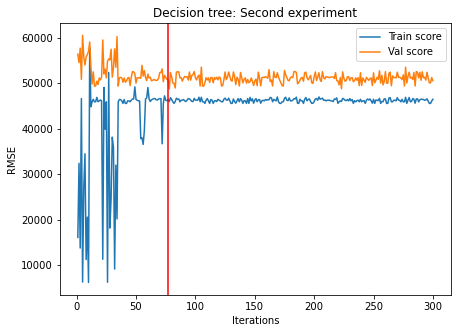

In [34]:
plt.figure(figsize=(7,5))
train_score=np.array(result_dt.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_dt.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Decision tree: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_dt.best_index_,c='r')
plt.show()

In [35]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "select__max_features":Integer(2,40)}

result_rf = BayesSearchCV(estimator=select_model(RandomForestRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_rf.fit(X_train,y_train.values.ravel())

print(result_rf.best_params_)
print(-result_rf.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__bootstrap', True), ('model__max_depth', 90), ('model__max_features', 0.5), ('model__max_samples', 0.5), ('model__n_estimators', 696), ('select__max_features', 40)])
42442.5515801152


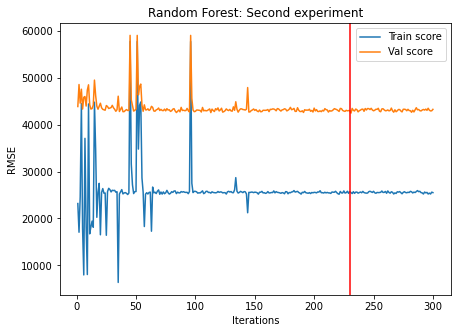

In [36]:
plt.figure(figsize=(7,5))
train_score=np.array(result_rf.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_rf.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Random Forest: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_rf.best_index_,c='r')
plt.show()

In [37]:
params={"model__n_estimators":Integer(100,1000),
       "model__learning_rate":Real(0.01,0.1),
       "select__max_features":Integer(2,40)}

result_ada = BayesSearchCV(estimator=select_model(AdaBoostRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_ada.fit(X_train,y_train.values.ravel())

print(result_ada.best_params_)
print(-result_ada.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__learning_rate', 0.049008876821731245), ('model__n_estimators', 100), ('select__max_features', 40)])
49063.088739182545


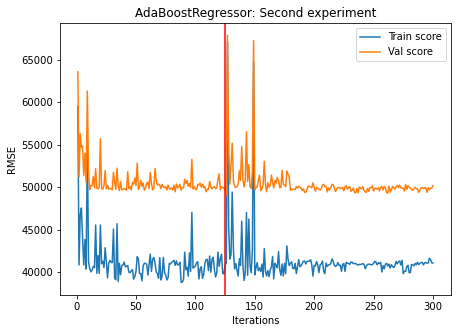

In [38]:
plt.figure(figsize=(7,5))
train_score=np.array(result_ada.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_ada.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('AdaBoostRegressor: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_ada.best_index_,c='r')
plt.show()

In [39]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "select__max_features":Integer(2,40)}

result_extra = BayesSearchCV(estimator=select_model(ExtraTreesRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)


result_extra.fit(X_train,y_train.values.ravel())

print(result_extra.best_params_)
print(-result_extra.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__bootstrap', True), ('model__max_depth', 48), ('model__max_features', 0.5), ('model__max_samples', 0.5), ('model__n_estimators', 1000), ('select__max_features', 40)])
41958.554485294444


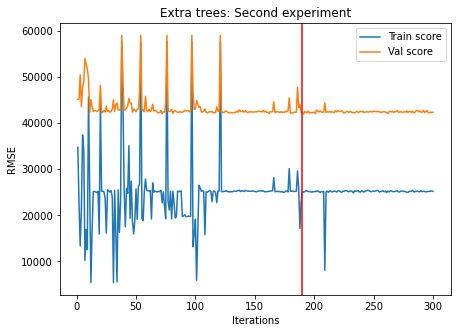

In [40]:
plt.figure(figsize=(7,5))
train_score=np.array(result_extra.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_extra.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Extra trees: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_extra.best_index_,c='r')
plt.show()

In [41]:
params={"model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "select__max_features":Integer(2,40)}

result_gbr = BayesSearchCV(estimator=select_model(GradientBoostingRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)

result_gbr.fit(X_train,y_train.values.ravel())

print(result_gbr.best_params_)
print(-result_gbr.best_score_)

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__max_depth', 3), ('model__max_features', 0.5), ('model__n_estimators', 100), ('model__subsample', 0.5), ('select__max_features', 40)])
38519.10962414703


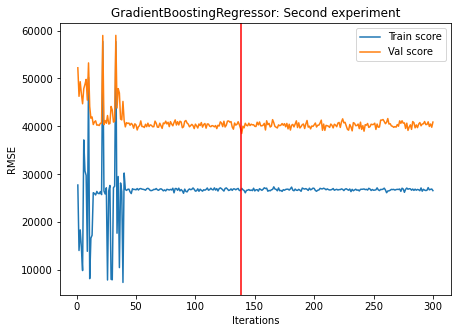

In [42]:
plt.figure(figsize=(7,5))
train_score=np.array(result_gbr.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_gbr.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('GradientBoostingRegressor: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_gbr.best_index_,c='r')
plt.show()

In [43]:
params={"model__learning_rate":Real(0.01,0.1),
       "model__max_depth":Integer(1,8),
       "model__n_estimators":Integer(100,1000),
       "model__colsample_bytree":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "select__max_features":Integer(2,40)}

result_xgb = BayesSearchCV(estimator=select_model(XGBRegressor(),col_transform2,selector=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True)
result_xgb.fit(X_train,y_train.values.ravel())

print(result_xgb.best_params_)
print(-result_xgb.best_score_)

OrderedDict([('model__colsample_bytree', 0.5), ('model__learning_rate', 0.039902582805208364), ('model__max_depth', 2), ('model__n_estimators', 418), ('model__subsample', 0.5), ('select__max_features', 40)])
41639.03498902535


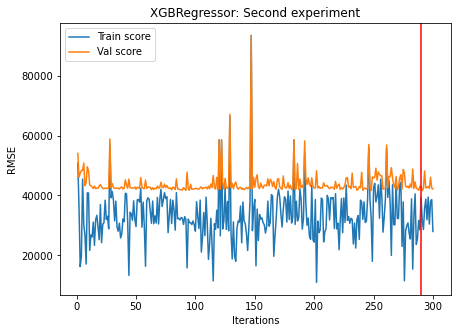

In [44]:
plt.figure(figsize=(7,5))
train_score=np.array(result_xgb.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_xgb.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('XGBRegressor: Second experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_xgb.best_index_,c='r')
plt.show()

In [45]:
cv_result=[result_dt,result_rf,result_extra,result_gbr,result_ada,result_xgb]
models=["DT","RF","EXT","GBR","ADA","XGB"]

results_2 = pd.DataFrame()

for i,j in zip(cv_result,models):
    results_2.loc[j,'RMSE train']=mean_squared_error(y_train,i.predict(X_train),squared=False)
    results_2.loc[j,'RMSE Val']=(i.best_score_)*(-1)
    results_2.loc[j,'RMSE test']=mean_squared_error(y_test,i.predict(X_test),squared=False)
#Difference between RMSE of the training set and the test set to see how far they are from one of another
results_2['Dif']=results_2['RMSE train']-results_2['RMSE test']
results_2['Best params']=0
results_2['Best params'] = results_2['Best params'].astype(object)
#Best hyperparameters selected by the Bayesian Search
for i,j in zip(cv_result,models):
    results_2.at[j,'Best params']=list(i.best_params_.items())
results_2

,RMSE train,RMSE Val,RMSE test,Dif,Best params
DT,46244.497000,48707.145209,53706.673266,-7462.176266,"[(model__max_depth, 10), (model__max_features, 0.5), (select__max_features, 5)]"
RF,24828.968701,42442.551580,35961.127561,-11132.158860,"[(model__bootstrap, True), (model__max_depth, 90), (model__max_features, 0.5), (model__max_samples, 0.5), (model__n_estimators, 696), (select__max_features, 40)]"
EXT,23995.347446,41958.554485,36130.498271,-12135.150825,"[(model__bootstrap, True), (model__max_depth, 48), (model__max_features, 0.5), (model__max_samples, 0.5), (model__n_estimators, 1000), (select__max_features, 40)]"
GBR,28119.677376,38519.109624,34375.964639,-6256.287263,"[(model__max_depth, 3), (model__max_features, 0.5), (model__n_estimators, 100), (model__subsample, 0.5), (select__max_features, 40)]"
ADA,42610.907881,49063.088739,41939.289083,671.618798,"[(model__learning_rate, 0.049008876821731245), (model__n_estimators, 100), (select__max_features, 40)]"
XGB,32635.245305,41639.034989,35804.863315,-3169.618010,"[(model__colsample_bytree, 0.5), (model__learning_rate, 0.039902582805208364), (model__max_depth, 2), (model__n_estimators, 418), (model__subsample, 0.5), (select__max_features, 40)]"


# Third experiment: Combine feature selection and dimension reduction

In [18]:
#A value error will rise because it fits the params with the "best score", in this case it will be 0 but only because
#this error was not calculated with the set of parameters given:
params={"model__max_depth":Integer(10,800),
       "model__max_features":Real(0.5,1),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}
#ValueError: n_components must be < n_features; got 29 >= 28
result_dt = BayesSearchCV(estimator=select_model(DecisionTreeRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                          error_score=-100000)

result_dt.fit(X_train,y_train.values.ravel())

print(result_dt.best_params_)
print(-result_dt.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anacon

OrderedDict([('model__max_depth', 10), ('model__max_features', 1.0), ('reduct__n_components', 5), ('select__max_features', 16)])
36011.5684706147


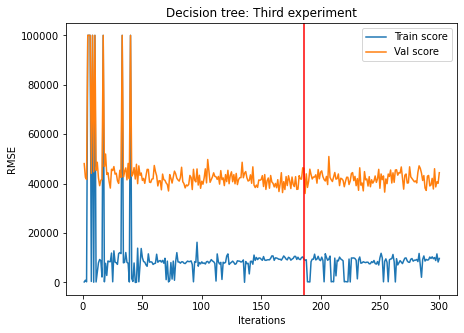

In [19]:
plt.figure(figsize=(7,5))
train_score=np.array(result_dt.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_dt.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Decision tree: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_dt.best_index_,c='r')
plt.show()

In [20]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}

result_rf = BayesSearchCV(estimator=select_model(RandomForestRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                          error_score=-100000)

result_rf.fit(X_train,y_train.values.ravel())

print(result_rf.best_params_)
print(-result_rf.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

OrderedDict([('model__bootstrap', True), ('model__max_depth', 100), ('model__max_features', 0.8583499480937977), ('model__max_samples', 0.99), ('model__n_estimators', 1000), ('reduct__n_components', 22), ('select__max_features', 38)])
30595.728009770257


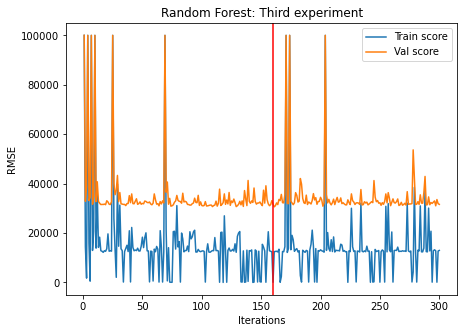

In [21]:
plt.figure(figsize=(7,5))
train_score=np.array(result_rf.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_rf.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Random Forest: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_rf.best_index_,c='r')
plt.show()

In [22]:
params={"model__n_estimators":Integer(100,1000),
       "model__learning_rate":Real(0.01,0.1),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}

result_ada = BayesSearchCV(estimator=select_model(AdaBoostRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                           error_score=-100000)

result_ada.fit(X_train,y_train.values.ravel())

print(result_ada.best_params_)
print(-result_ada.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_tr

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('model__learning_rate', 0.1), ('model__n_estimators', 1000), ('reduct__n_components', 19), ('select__max_features', 40)])
31224.559819543167


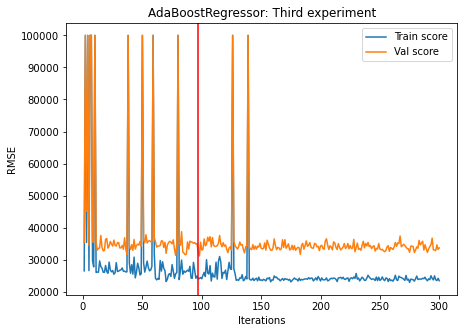

In [23]:
plt.figure(figsize=(7,5))
train_score=np.array(result_ada.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_ada.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('AdaBoostRegressor: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_ada.best_index_,c='r')
plt.show()

In [24]:
params={"model__bootstrap":[True,False],
       "model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__max_samples":Real(0.5,0.99),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}

result_extra = BayesSearchCV(estimator=select_model(ExtraTreesRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                            error_score=-100000)


result_extra.fit(X_train,y_train.values.ravel())

print(result_extra.best_params_)
print(-result_extra.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

OrderedDict([('model__bootstrap', False), ('model__max_depth', 90), ('model__max_features', 1.0), ('model__max_samples', 0.5), ('model__n_estimators', 1000), ('reduct__n_components', 20), ('select__max_features', 40)])
29609.716893628414


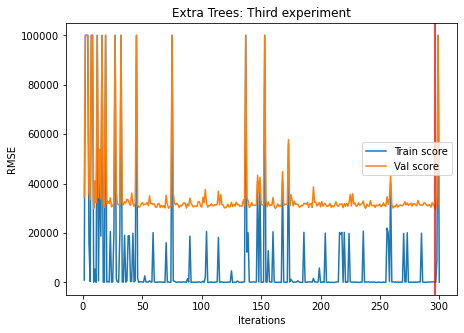

In [25]:
plt.figure(figsize=(7,5))
train_score=np.array(result_extra.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_extra.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('Extra Trees: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_extra.best_index_,c='r')
plt.show()

In [26]:
params={"model__max_depth":Integer(3,100),
       "model__n_estimators":Integer(100,1000),
       "model__max_features":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}

result_gbr = BayesSearchCV(estimator=select_model(GradientBoostingRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                          error_score=-100000)

result_gbr.fit(X_train,y_train.values.ravel())

print(result_gbr.best_params_)
print(-result_gbr.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

OrderedDict([('model__max_depth', 3), ('model__max_features', 1.0), ('model__n_estimators', 791), ('model__subsample', 0.5), ('reduct__n_components', 23), ('select__max_features', 27)])
26665.590976741212


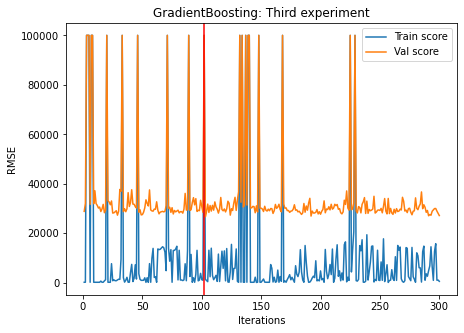

In [27]:
plt.figure(figsize=(7,5))
train_score=np.array(result_gbr.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_gbr.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('GradientBoosting: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_gbr.best_index_,c='r')
plt.show()

In [28]:
params={"model__learning_rate":Real(0.01,0.1),
       "model__max_depth":Integer(1,8),
       "model__n_estimators":Integer(100,1000),
       "model__colsample_bytree":Real(0.5,1),
       "model__subsample":Real(0.5,1),
       "select__max_features":Integer(2,40),
       'reduct__n_components':Integer(2,40)}

result_xgb = BayesSearchCV(estimator=select_model(XGBRegressor(),col_transform1,selector=True,dim_red=True),
                             search_spaces=params, 
                             cv=3,
                             n_iter=300,
                            scoring='neg_root_mean_squared_error',iid=False,return_train_score=True,
                          error_score=-100000)
result_xgb.fit(X_train,y_train.values.ravel())

print(result_xgb.best_params_)
print(-result_xgb.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to -100000.000000. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 330, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 292, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 740, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  

OrderedDict([('model__colsample_bytree', 0.9365864168611291), ('model__learning_rate', 0.01), ('model__max_depth', 3), ('model__n_estimators', 803), ('model__subsample', 0.6147211308674698), ('reduct__n_components', 14), ('select__max_features', 27)])
27842.446592076827


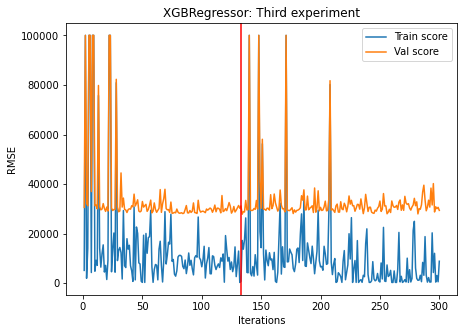

In [29]:
plt.figure(figsize=(7,5))
train_score=np.array(result_xgb.cv_results_['mean_train_score'])*(-1)
val_score=np.array(result_xgb.cv_results_['mean_test_score'])*(-1)
plt.plot(np.arange(1,301),train_score,label='Train score')
plt.plot(np.arange(1,301),val_score,label='Val score')
plt.legend()
plt.title('XGBRegressor: Third experiment')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.axvline(result_xgb.best_index_,c='r')
plt.show()

In [30]:
cv_result=[result_dt,result_rf,result_extra,result_gbr,result_ada,result_xgb]
models=["DT","RF","EXT","GBR","ADA","XGB"]

results_3 = pd.DataFrame()

for i,j in zip(cv_result,models):
    results_3.loc[j,'RMSE train']=mean_squared_error(y_train,i.predict(X_train),squared=False)
    results_3.loc[j,'RMSE Val']=(i.best_score_)*(-1)
    results_3.loc[j,'RMSE test']=mean_squared_error(y_test,i.predict(X_test),squared=False)
#Difference between RMSE of the training set and the test set to see how far they are from one of another
results_3['Dif']=results_3['RMSE train']-results_3['RMSE test']
results_3['Best params']=0
results_3['Best params'] = results_3['Best params'].astype(object)
#Best hyperparameters selected by the Bayesian Search
for i,j in zip(cv_result,models):
    results_3.at[j,'Best params']=list(i.best_params_.items())
results_3

,RMSE train,RMSE Val,RMSE test,Dif,Best params
DT,8573.419747,36011.568471,31950.200135,-23376.780388,"[(model__max_depth, 10), (model__max_features, 1.0), (reduct__n_components, 5), (select__max_features, 16)]"
RF,11795.887519,30595.728010,26286.589404,-14490.701886,"[(model__bootstrap, True), (model__max_depth, 100), (model__max_features, 0.8583499480937977), (model__max_samples, 0.99), (model__n_estimators, 1000), (reduct__n_components, 22), (select__max_features, 38)]"
EXT,155.889138,29609.716894,24177.765702,-24021.876563,"[(model__bootstrap, False), (model__max_depth, 90), (model__max_features, 1.0), (model__max_samples, 0.5), (model__n_estimators, 1000), (reduct__n_components, 20), (select__max_features, 40)]"
GBR,2857.222946,26665.590977,22153.643351,-19296.420405,"[(model__max_depth, 3), (model__max_features, 1.0), (model__n_estimators, 791), (model__subsample, 0.5), (reduct__n_components, 23), (select__max_features, 27)]"
ADA,25432.819767,31224.559820,28499.216074,-3066.396307,"[(model__learning_rate, 0.1), (model__n_estimators, 1000), (reduct__n_components, 19), (select__max_features, 40)]"
XGB,17662.408177,27842.446592,23852.859648,-6190.451471,"[(model__colsample_bytree, 0.9365864168611291), (model__learning_rate, 0.01), (model__max_depth, 3), (model__n_estimators, 803), (model__subsample, 0.6147211308674698), (reduct__n_components, 14), (select__max_features, 27)]"
